In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torchvision import transforms
from torch.utils.data import Dataset

#plot
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np 


In [5]:
def plot_single_entropy(data, data_ref, color, ax, bins, msg, xtext = 0.28, ytext = 0.63):
    
    SMALL_SIZE = 12
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)
    
    h, _, img = ax.hist(data_ref, bins=(x_bins), edgecolor = "black", color = "orange")
    h, _, img = ax.hist(data, bins=(x_bins), edgecolor = "black", color = color, alpha = 0.5)
    
    ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=12)
    ax.set_ylim([0, 1600])
    plt.yticks([500, 1000, 1500], ['','',''])
    plt.xticks([0, 1], ['',''])
    plt.grid(b=True)

In [6]:
def plot_single_MI(data, data_ref, color, ax, bins, msg, xtext = 0.28, ytext = 0.63):
    
    SMALL_SIZE = 12
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)
    
    h, _, img = ax.hist(data_ref, bins=(x_bins), edgecolor = "black", color = "orange")
    h, _, img = ax.hist(data, bins=(x_bins), edgecolor = "black", color = color, alpha = 0.5)
    
    ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=12)
    ax.set_ylim([0, 1600])
    plt.yticks([500, 1000, 1500], ['','',''])
    plt.xticks([0, 0.5], ['',''])
    plt.grid(b=True)


In [7]:
import numpy as np
import dill as pickle

def read_res_from_dill(path):  
    with open(path, 'rb') as fp:
        res = pickle.load(fp)   
    return res

def calculate_mean_softmax_probs (softmax_probs_ensemble: torch.Tensor) -> torch.Tensor:

    mean_softmax_probs = torch.mean(softmax_probs_ensemble, dim=0)
    return mean_softmax_probs


def calculate_entropy_ens(
    softmax_probs_ensemble: torch.Tensor, 
    dim: int = -1, 
    eps: float = 1e-9
) -> torch.Tensor:

    softmax_probs = calculate_mean_softmax_probs(softmax_probs_ensemble)
    entropy = calculate_entropy(softmax_probs, dim, eps)

    return entropy

def calculate_entropy(
    softmax_probs: torch.Tensor, 
    dim: int = -1, 
    eps: float = 1e-9
) -> torch.Tensor:
    entropy = -torch.sum(softmax_probs * torch.log(softmax_probs + eps), dim=dim)
    return entropy

def calculate_mutual_information_ens(
    softmax_probs_ensemble: torch.Tensor
) -> torch.Tensor:

    entropy_of_the_mean_ens_prob = calculate_entropy_ens(softmax_probs_ensemble)
    mean_ens_entropy = torch.mean(calculate_entropy(softmax_probs_ensemble), dim=0)
    
    mutual_information = entropy_of_the_mean_ens_prob - mean_ens_entropy

    return mutual_information

In [8]:
import os
path_dir = "/mimer/NOBACKUP/groups/snic2022-22-448/lora_ensembles/ens_llm_lora_evaluate/train_commonsense_qa/ens/4/dataset_commonsense_qa"
path_files = []
names = []

path_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_8_dr_0_rl2_0_rl2_1.dill")
names.append("LORA L2=1 \n DR=0")

path_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_8_dr_0d1_rl2_0_rl2_1.dill")
names.append("Lora L2=1 \n DR=0.1")

path_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_8_dr_0d1_rl2_0_rl2_0d1.dill")
names.append("Lora L2=0.1 \n DR=0.1")

path_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_8_dr_0_rl2_0d001_rl2_0.dill")
names.append("Reg. L2=0.001 \n DR=0")

In [9]:
full_res_dic = {}
for index, path_file in enumerate(path_files):
    name = names[index]
    accumulated_ens_probs = []
    for member_id in range(5):
        full_path_file = os.path.join(path_dir, str(member_id), path_file)
        res = read_res_from_dill(full_path_file)
        accumulated_ens_probs.append(res['softmax_probs'].unsqueeze(0))
    targets = res['targets']
    
    full_res_dic[name] = torch.cat(accumulated_ens_probs)

[0.38991833 0.02327417 0.05201586 ... 0.03873804 0.0145406  0.06230062]
Regular entropies:  0.3060721
[0.36273837 0.02518264 0.05818495 ... 0.04571812 0.01624859 0.07610866]
Regular entropies:  0.3132559
[0.25017494 0.01615279 0.03607381 ... 0.03015813 0.01052117 0.05315256]
Regular entropies:  0.279755
[0.23933324 0.01063581 0.02690637 ... 0.02064134 0.00645059 0.04718295]
Regular entropies:  0.25975424
[5.8642983e-02 2.1681748e-04 3.8747489e-04 ... 6.2951446e-04 5.8327802e-05
 6.1706081e-04]
Regular entropies:  0.024186736
[0.04110569 0.00032246 0.00034489 ... 0.00105756 0.00012605 0.00100512]
Regular entropies:  0.022545764
[1.38338655e-02 1.55864283e-04 4.06436622e-04 ... 5.45023009e-04
 8.58893618e-05 6.09871000e-04]
Regular entropies:  0.027104048
[2.2815466e-02 6.7548826e-05 2.5393069e-04 ... 3.0042790e-04 5.0101429e-05
 9.7322091e-04]
Regular entropies:  0.027617427


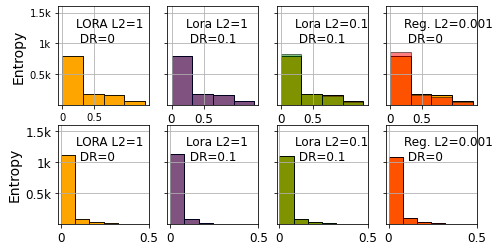

In [10]:
import copy
classes = 5
x_bins = np.arange(0, np.log(classes), np.log(classes)/5)
xtext = 0.15
ytext = 0.53

fig = plt.figure(figsize=(2.5*3, 4))

# create grid for different subplots
spec = fig.add_gridspec(2, 4)

# CIFAR-10 HMC
num_nets = 5
name = names[0]

softprobs = full_res_dic[name]
entropies = calculate_entropy_ens(softprobs)
entropies = entropies.numpy()
entropies_ref = copy.deepcopy(entropies)
print(entropies)
print("Regular entropies: ", np.mean(np.abs(entropies)))

ax = fig.add_subplot(spec[0, 0])
msg = name
color = "orange"
xtext = 0.2
ytext = 0.64
plot_single_entropy(entropies, entropies_ref, color, ax, x_bins, msg, xtext = xtext, ytext = ytext)

plt.ylabel("Entropy", fontsize=14) 
plt.yticks([500, 1000, 1500], ['0.5k','1k','1.5k'])
plt.xticks([0, 0.5], ['0','0.5'])


# CIFAR-10 HMC
num_nets = 5
name = names[1]

softprobs = full_res_dic[name]
entropies = calculate_entropy_ens(softprobs)
entropies = entropies.numpy()
print(entropies)
print("Regular entropies: ", np.mean(np.abs(entropies)))

ax = fig.add_subplot(spec[0, 1])
msg = name
color = "blue"
xtext = 0.2
ytext = 0.64
plot_single_entropy(entropies, entropies_ref, color, ax, x_bins, msg, xtext = xtext, ytext = ytext)
plt.xticks([0, 0.5], ['0','0.5'])


# CIFAR-10 HMC
num_nets = 5
name = names[2]

softprobs = full_res_dic[name]
entropies = calculate_entropy_ens(softprobs)
entropies = entropies.numpy()
print(entropies)
print("Regular entropies: ", np.mean(np.abs(entropies)))

ax = fig.add_subplot(spec[0, 2])
msg = name
color = "green"
xtext = 0.2
ytext = 0.64
plot_single_entropy(entropies, entropies_ref, color, ax, x_bins, msg, xtext = xtext, ytext = ytext)
plt.xticks([0, 0.5], ['0','0.5'])

# CIFAR-10 HMC
num_nets = 5
name = names[3]

softprobs = full_res_dic[name]
entropies = calculate_entropy_ens(softprobs)
entropies = entropies.numpy()
print(entropies)
print("Regular entropies: ", np.mean(np.abs(entropies)))

ax = fig.add_subplot(spec[0, 3])
msg = name
color = "red"
xtext = 0.2
ytext = 0.64
plot_single_entropy(entropies, entropies_ref, color, ax, x_bins, msg, xtext = xtext, ytext = ytext)
plt.xticks([0, 0.5], ['0','0.5'])

# CIFAR-10 HMC

classes = 5
x_bins = np.arange(0, np.log(classes)/4, np.log(classes)/20)
xtext = 0.15
ytext = 0.53
num_nets = 5
name = names[0]

softprobs = full_res_dic[name]
mutual_info = calculate_mutual_information_ens(softprobs)
mutual_info = mutual_info.numpy()
mutual_info_ref = copy.deepcopy(mutual_info)
print(mutual_info)
print("Regular entropies: ", np.mean(np.abs(mutual_info)))

ax = fig.add_subplot(spec[1, 0])
msg = name
color = "orange"
xtext = 0.2
ytext = 0.64
plot_single_MI(mutual_info, mutual_info_ref, color, ax, x_bins, msg, xtext = xtext, ytext = ytext)

plt.ylabel("Entropy", fontsize=14) 
plt.yticks([500, 1000, 1500], ['0.5k','1k','1.5k'])
plt.xticks([0, 0.5], ['0','0.5'])


# CIFAR-10 HMC
num_nets = 5
name = names[1]

softprobs = full_res_dic[name]
mutual_info = calculate_mutual_information_ens(softprobs)
mutual_info = mutual_info.numpy()
mutual_info_ref = copy.deepcopy(mutual_info)
print(mutual_info)
print("Regular entropies: ", np.mean(np.abs(mutual_info)))

ax = fig.add_subplot(spec[1, 1])
msg = name
color = "blue"
xtext = 0.2
ytext = 0.64
plot_single_MI(mutual_info, mutual_info_ref, color, ax, x_bins, msg, xtext = xtext, ytext = ytext)
plt.xticks([0, 0.5], ['0','0.5'])


# CIFAR-10 HMC
num_nets = 5
name = names[2]

softprobs = full_res_dic[name]
mutual_info = calculate_mutual_information_ens(softprobs)
mutual_info = mutual_info.numpy()
mutual_info_ref = copy.deepcopy(mutual_info)
print(mutual_info)
print("Regular entropies: ", np.mean(np.abs(mutual_info)))

ax = fig.add_subplot(spec[1, 2])
msg = name
color = "green"
xtext = 0.2
ytext = 0.64
plot_single_MI(mutual_info, mutual_info_ref, color, ax, x_bins, msg, xtext = xtext, ytext = ytext)
plt.xticks([0, 0.5], ['0','0.5'])

# CIFAR-10 HMC
num_nets = 5
name = names[3]

softprobs = full_res_dic[name]
mutual_info = calculate_mutual_information_ens(softprobs)
mutual_info = mutual_info.numpy()
mutual_info_ref = copy.deepcopy(mutual_info)
print(mutual_info)
print("Regular entropies: ", np.mean(np.abs(mutual_info)))

ax = fig.add_subplot(spec[1, 3])
msg = name
color = "red"
xtext = 0.2
ytext = 0.64
plot_single_MI(mutual_info, mutual_info_ref, color, ax, x_bins, msg, xtext = xtext, ytext = ytext)
plt.xticks([0, 0.5], ['0','0.5'])




plt.savefig('entropies.pdf', format='pdf', bbox_inches='tight')

In [11]:
import os
path_dirs = []
path_files = []
names = []

path_dirs.append("/mimer/NOBACKUP/groups/snic2022-22-448/lora_ensembles/ens_llm_lora_evaluate/train_commonsense_qa/ens/3/dataset_commonsense_qa")
path_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_8_dr_0_rl2_0_rl2_1.dill")
names.append("Lora L2 = 1, DR = 0, DS = commonsese_qa")

path_dirs.append("/mimer/NOBACKUP/groups/snic2022-22-448/lora_ensembles/ens_llm_lora_evaluate/train_commonsense_qa/ens/3/dataset_mmlu_stem")
path_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_8_dr_0_rl2_0_rl2_1.dill")
names.append("Lora L2 = 1, DR = 0, DS = mmlu_stem")

path_dirs.append("/mimer/NOBACKUP/groups/snic2022-22-448/lora_ensembles/ens_llm_lora_evaluate/train_commonsense_qa/ens/3/dataset_mmlu_ss")
path_files.append("member_probs_and_targets_Mistral-7B-v0d1_lr_8_dr_0_rl2_0_rl2_1.dill")
names.append("Lora L2 = 1, DR = 0, DS = mmlu_ss")

In [12]:
entropy_res_dic = {}
mutual_info_res_dic = {}
for index, path_file in enumerate(path_files):
    name = names[index]
    accumulated_ens_probs = []
    for member_id in range(5):
        full_path_file = os.path.join(path_dirs[index], str(member_id), path_file)
        res = read_res_from_dill(full_path_file)
        accumulated_ens_probs.append(res['softmax_probs'].unsqueeze(0))
    targets = res['targets']
    
    softprobs = torch.cat(accumulated_ens_probs)
    mean_softprobs = calculate_mean_softmax_probs(softprobs)
    softprobs_correct = softprobs[:, torch.argmax(mean_softprobs, dim=-1)==targets] 
    softprobs_wrong = softprobs[:, torch.argmax(mean_softprobs, dim=-1)!=targets] 
    
    entropies = calculate_entropy_ens(softprobs_correct)
    mutual_info = calculate_mutual_information_ens(softprobs_correct)
    
    entropy_res_dic[name+"_correct"] = entropies
    mutual_info_res_dic[name+"_correct"] = mutual_info
    
    entropies = calculate_entropy_ens(softprobs_wrong)
    mutual_info = calculate_mutual_information_ens(softprobs_wrong)
    
    entropy_res_dic[name+"_wrong"] = entropies
    mutual_info_res_dic[name+"_wrong"] = mutual_info

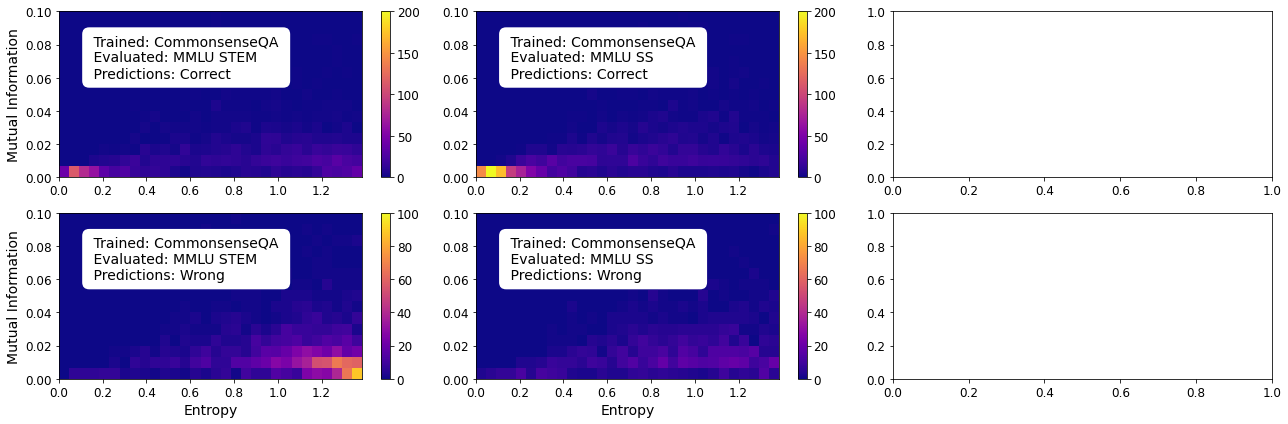

In [15]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Assuming your data is something like this (replace with your actual data)

# Create a figure with subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 6))
classes = 4
x_range = (0, np.log(classes))  
y_range = (0, 0.2)  

xtext = 0.1
ytext = 0.6


# Dataset 1
name = names[0]+"_correct"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()

# Dataset 2
name = names[1]+"_correct"
x2 = entropy_res_dic[name].numpy()
y2 = mutual_info_res_dic[name].numpy()

name = names[2]+"_correct"
x3 = entropy_res_dic[name].numpy()
y3 = mutual_info_res_dic[name].numpy()


# 2D histogram for Dataset 1
ax = axs[0][0]
name = names[1]+"_correct"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=30, cmap='plasma',norm=colors.Normalize(vmin=0, vmax=200), range=[x_range, y_range])
ax.set_ylabel('Mutual Information', fontsize=14)
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
msg = " Trained: CommonsenseQA \n Evaluated: MMLU STEM \n Predictions: Correct"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=14,
           bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5'))
fig.colorbar(image1, ax=ax)

# 2D histogram for Dataset 1
ax = axs[1][0]
name = names[1]+"_wrong"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=30, cmap='plasma',norm=colors.Normalize(vmin=0, vmax=100), range=[x_range, y_range])
ax.set_xlabel('Entropy', fontsize=14)
ax.set_ylabel('Mutual Information', fontsize=14)
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
msg = " Trained: CommonsenseQA \n Evaluated: MMLU STEM \n Predictions: Wrong"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=14,
           bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5'))
fig.colorbar(image1, ax=ax)

# 2D histogram for Dataset 1
ax = axs[0][1]
name = names[2]+"_correct"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=30, norm=colors.Normalize(vmin=0, vmax=200), cmap='plasma', range=[x_range, y_range])
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
msg = " Trained: CommonsenseQA \n Evaluated: MMLU SS \n Predictions: Correct"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=14,
           bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5'))
fig.colorbar(image1, ax=ax)

# 2D histogram for Dataset 1
ax = axs[1][1]
name = names[2]+"_wrong"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()
hist1, xedges, yedges, image1 = ax.hist2d(x1, y1, bins=30, norm=colors.Normalize(vmin=0, vmax=100), cmap='plasma', range=[x_range, y_range])
ax.set_xlabel('Entropy', fontsize=14)
ax.set_ylim(0, 0.1)
ax.set_xlim(0, np.log(classes))
msg = " Trained: CommonsenseQA \n Evaluated: MMLU SS \n Predictions: Wrong"
ax.text(xtext, ytext, msg, transform=ax.transAxes, fontsize=14,
           bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5'))
fig.colorbar(image1, ax=ax)






# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Assuming your data is something like this (replace with your actual data)

# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
x_range = (0, 1.5)  
y_range = (0, 0.2)  


# Dataset 1
name = names[0]+"_wrong"
x1 = entropy_res_dic[name].numpy()
y1 = mutual_info_res_dic[name].numpy()

# Dataset 2
name = names[1]+"_wrong"
x2 = entropy_res_dic[name].numpy()
y2 = mutual_info_res_dic[name].numpy()

name = names[2]+"_wrong"
x3 = entropy_res_dic[name].numpy()
y3 = mutual_info_res_dic[name].numpy()


# 2D histogram for Dataset 1
hist1, xedges, yedges, image1 = axs[0].hist2d(x1, y1, bins=30, cmap='plasma', range=[x_range, y_range])
axs[0].set_title('Dataset 1')
axs[0].set_xlabel('Entropy')
axs[0].set_ylabel('Mutual Information')
axs[0].set_ylim(0, 0.1)
axs[0].set_xlim(0, 1.6)
fig.colorbar(image1, ax=axs[0], label='Density')

# 2D histogram for Dataset 2
hist2, xedges, yedges, image2 = axs[1].hist2d(x2, y2, bins=30, cmap='plasma', range=[x_range, y_range])
axs[1].set_title('Dataset 2')
axs[1].set_xlabel('Entropy')
axs[1].set_ylabel('Mutual Information')
axs[1].set_ylim(0, 0.1)
axs[1].set_xlim(0, 1.6)
fig.colorbar(image2, ax=axs[1], label='Density')

hist3, xedges, yedges, image3 = axs[2].hist2d(x3, y3, bins=30, cmap='plasma', range=[x_range, y_range])
axs[2].set_title('Dataset 3')
axs[2].set_xlabel('Entropy')
axs[2].set_ylabel('Mutual Information')
axs[2].set_ylim(0, 0.1)
axs[2].set_xlim(0, 1.6)
fig.colorbar(image2, ax=axs[2], label='Density')

# Show the plot
plt.tight_layout()
plt.show()
